<a href="https://colab.research.google.com/github/bislara/InfoGAN-PyTorch/blob/master/InfoGAN_MNIST_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!mkdir .kaggle

In [0]:
import json

token = {"username":"biswajeetsahoo54","key":"1ce5cac341a71f094959287c3a210236"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!cp /content/.kaggle/kaggle.json  /root/.kaggle/kaggle.json

In [7]:
!kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
unanimad/dataisbeautiful                                       Reddit - Data is Beautiful                           11MB  2020-03-21 22:28:28            908  
allen-institute-for-ai/CORD-19-research-challenge              COVID-19 Open Research Dataset Challenge (CORD-19)  646MB  2020-03-20 23:31:34          30732  
rubenssjr/brasilian-houses-to-rent                             brazilian_houses_to_rent                            282KB  2020-03-25 22:51:17            867  
paultimothymooney/covid19-containment-and-mitigation-measures  COVID-19 containment and mitigation measures         91KB  2020-03-25 13:00:11            100  
sudalairajkumar/novel-corona-virus-2019-datase

In [8]:
!kaggle datasets download -d zalando-research/fashionmnist

 95% 65.0M/68.8M [00:00<00:00, 65.5MB/s]
100% 68.8M/68.8M [00:00<00:00, 101MB/s] 


In [9]:
!unzip \*.zip

Archive:  fashionmnist.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import random
from torch.utils.data import Dataset, DataLoader

In [12]:
seed = 999
random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)

Random Seed:  999


In [13]:
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
print(device, " will be used.\n")

cuda:0  will be used.



In [0]:
import pandas as pd
from PIL import Image

class FashionMNIST(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv('fashion-mnist_train.csv')
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        return img

In [15]:
dataset = FashionMNIST()
print(dataset)
print(len(dataset))
# print((dataset[1][0].size))

60000


In [0]:
from torchvision import transforms

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])
dataset = FashionMNIST(transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

In [17]:
print(dataloader)
print(len(dataloader))

15000


torch.Size([4, 1, 28, 28])


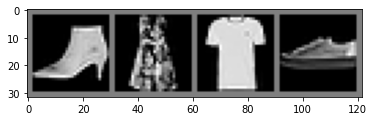

In [18]:
import torchvision

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get rand image
dataiter = iter(dataloader)
images = dataiter.next()

print(images.size())
# show images
imshow(torchvision.utils.make_grid(images))

In [0]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [0]:
import torch.nn.functional as F

"""
Architecture based on InfoGAN paper.
"""

class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.tconv1 = nn.ConvTranspose2d(74, 1024, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(1024)

        self.tconv2 = nn.ConvTranspose2d(1024, 128, 7, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)

        self.tconv3 = nn.ConvTranspose2d(128, 64, 4, 2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(64)

        self.tconv4 = nn.ConvTranspose2d(64, 1, 4, 2, padding=1, bias=False)

    def forward(self, x):
        x = F.relu(self.bn1(self.tconv1(x)))
        x = F.relu(self.bn2(self.tconv2(x)))
        x = F.relu(self.bn3(self.tconv3(x)))

        img = torch.sigmoid(self.tconv4(x))

        return img

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 64, 4, 2, 1)

        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(128, 1024, 7, bias=False)
        self.bn3 = nn.BatchNorm2d(1024)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.1, inplace=True)
        x = F.leaky_relu(self.bn2(self.conv2(x)), 0.1, inplace=True)
        x = F.leaky_relu(self.bn3(self.conv3(x)), 0.1, inplace=True)

        return x

In [0]:
class DHead(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Conv2d(1024, 1, 1)

    def forward(self, x):
        output = torch.sigmoid(self.conv(x))

        return output

In [0]:
class QHead(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1024, 128, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(128)

        self.conv_disc = nn.Conv2d(128, 10, 1)
        self.conv_mu = nn.Conv2d(128, 2, 1)
        self.conv_var = nn.Conv2d(128, 2, 1)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)), 0.1, inplace=True)

        disc_logits = self.conv_disc(x).squeeze()

        mu = self.conv_mu(x).squeeze()
        var = torch.exp(self.conv_var(x).squeeze())

        return disc_logits, mu, var

In [25]:
# Initialise the network.
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
print(discriminator)

netD = DHead().to(device)
netD.apply(weights_init)
print(netD)

netQ = QHead().to(device)
netQ.apply(weights_init)
print(netQ)

Generator(
  (tconv1): ConvTranspose2d(74, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(1024, 128, kernel_size=(7, 7), stride=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv4): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)
Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 1024, kernel_size=(7, 7), stride=(1, 1), bias=False)
 

In [0]:
class NormalNLLLoss:
    """
    Calculate the negative log likelihood
    of normal distribution.
    This needs to be minimised.
    Treating Q(cj | x) as a factored Gaussian.
    """
    def __call__(self, x, mu, var):
        
        logli = -0.5 * (var.mul(2 * np.pi) + 1e-6).log() - (x - mu).pow(2).div(var.mul(2.0) + 1e-6)
        nll = -(logli.sum(1).mean())

        return nll

In [0]:
# Loss for discrimination between real and fake images.
criterionD = nn.BCELoss()
# Loss for discrete latent code.
criterionQ_dis = nn.CrossEntropyLoss()
# Loss for continuous latent code.

criterionQ_con = NormalNLLLoss()

In [0]:
# Adam optimiser is used.
optimD = optim.Adam([{'params': discriminator.parameters()}, {'params': netD.parameters()}], betas=(0.5,0.999),lr=0.0002)
optimG = optim.Adam([{'params': netG.parameters()}, {'params': netQ.parameters()}], betas=(0.5,0.999),lr=0.0002)


In [0]:
params = {
    'batch_size': 4,# Batch size.
    'num_epochs': 5,# Number of epochs to train for.
    'learning_rate': 2e-4,# Learning rate.
    'beta1': 0.5,
    'beta2': 0.999,
    'save_epoch' : 2, # After how many epochs to save checkpoints and generate test output.
    'dataset' : 'FashionMNIST'}

# Set appropriate hyperparameters depending on the dataset used.
# The values given in the InfoGAN paper are used.
# num_z : dimension of incompressible noise.
# num_dis_c : number of discrete latent code used.
# dis_c_dim : dimension of discrete latent code.
# num_con_c : number of continuous latent code used.
params['num_z'] = 62
params['num_dis_c'] = 1
params['dis_c_dim'] = 10
params['num_con_c'] = 2

In [0]:
# Fixed Noise
z = torch.randn(100, params['num_z'], 1, 1, device=device)
fixed_noise = z
if(params['num_dis_c'] != 0):
    idx = np.arange(params['dis_c_dim']).repeat(10)
    dis_c = torch.zeros(100, params['num_dis_c'], params['dis_c_dim'], device=device)
    for i in range(params['num_dis_c']):
        dis_c[torch.arange(0, 100), i, idx] = 1.0

    dis_c = dis_c.view(100, -1, 1, 1)

    fixed_noise = torch.cat((fixed_noise, dis_c), dim=1)

if(params['num_con_c'] != 0):
    con_c = torch.rand(100, params['num_con_c'], 1, 1, device=device) * 2 - 1
    fixed_noise = torch.cat((fixed_noise, con_c), dim=1)


In [0]:
real_label = 1
fake_label = 0

# List variables to store results pf training.
img_list = []
G_losses = []
D_losses = []

In [0]:
def noise_sample(n_dis_c, dis_c_dim, n_con_c, n_z, batch_size, device):
    """
    Sample random noise vector for training.
    INPUT
    --------
    n_dis_c : Number of discrete latent code.
    dis_c_dim : Dimension of discrete latent code.
    n_con_c : Number of continuous latent code.
    n_z : Dimension of iicompressible noise.
    batch_size : Batch Size
    device : GPU/CPU
    """

    z = torch.randn(batch_size, n_z, 1, 1, device=device)

    idx = np.zeros((n_dis_c, batch_size))
    if(n_dis_c != 0):
        dis_c = torch.zeros(batch_size, n_dis_c, dis_c_dim, device=device)
        
        for i in range(n_dis_c):
            idx[i] = np.random.randint(dis_c_dim, size=batch_size)
            dis_c[torch.arange(0, batch_size), i, idx[i]] = 1.0

        dis_c = dis_c.view(batch_size, -1, 1, 1)

    if(n_con_c != 0):
        # Random uniform between -1 and 1.
        con_c = torch.rand(batch_size, n_con_c, 1, 1, device=device) * 2 - 1

    noise = z
    if(n_dis_c != 0):
        noise = torch.cat((z, dis_c), dim=1)
    if(n_con_c != 0):
        noise = torch.cat((noise, con_c), dim=1)

    return noise, idx

In [35]:
print("-"*25)
print("Starting Training Loop...\n")
print('Epochs: %d\nDataset: {}\nBatch Size: %d\nLength of Data Loader: %d'.format(params['dataset']) % (params['num_epochs'], params['batch_size'], len(dataloader)))
print("-"*25)

start_time = time.time()
iters = 0

for epoch in range(params['num_epochs']):
    epoch_start_time = time.time()

    for i, data in enumerate(dataloader, 0):
        # Get batch size
        b_size = data.size(0)
        # Transfer data tensor to GPU/CPU (device)
        real_data = data.to(device)

        # Updating discriminator and DHead
        optimD.zero_grad()
        # Real data
        label = torch.full((b_size, ), real_label, device=device)
        output1 = discriminator(real_data)
        probs_real = netD(output1).view(-1)
        loss_real = criterionD(probs_real, label)
        # Calculate gradients.
        loss_real.backward()

        # Fake data
        label.fill_(fake_label)
        noise, idx = noise_sample(params['num_dis_c'], params['dis_c_dim'], params['num_con_c'], params['num_z'], b_size, device)
        fake_data = netG(noise)
        output2 = discriminator(fake_data.detach())
        probs_fake = netD(output2).view(-1)
        loss_fake = criterionD(probs_fake, label)
        # Calculate gradients.
        loss_fake.backward()

        # Net Loss for the discriminator
        D_loss = loss_real + loss_fake
        # Update parameters
        optimD.step()

        # Updating Generator and QHead
        optimG.zero_grad()

        # Fake data treated as real.
        output = discriminator(fake_data)
        label.fill_(real_label)
        probs_fake = netD(output).view(-1)
        gen_loss = criterionD(probs_fake, label)

        q_logits, q_mu, q_var = netQ(output)
        target = torch.LongTensor(idx).to(device)
        # Calculating loss for discrete latent code.
        dis_loss = 0
        for j in range(params['num_dis_c']):
            dis_loss += criterionQ_dis(q_logits[:, j*10 : j*10 + 10], target[j])

        # Calculating loss for continuous latent code.
        con_loss = 0
        if (params['num_con_c'] != 0):
            con_loss = criterionQ_con(noise[:, params['num_z']+ params['num_dis_c']*params['dis_c_dim'] : ].view(-1, params['num_con_c']), q_mu, q_var)*0.1

        # Net loss for generator.
        G_loss = gen_loss + dis_loss + con_loss
        # Calculate gradients.
        G_loss.backward()
        # Update parameters.
        optimG.step()

        # Check progress of training.
        if i != 0 and i%100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch+1, params['num_epochs'], i, len(dataloader), 
                    D_loss.item(), G_loss.item()))

        # Save the losses for plotting.
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        iters += 1

    epoch_time = time.time() - epoch_start_time
    print("Time taken for Epoch %d: %.2fs" %(epoch + 1, epoch_time))
    # Generate image after each epoch to check performance of the generator. Used for creating animated gif later.
    with torch.no_grad():
        gen_data = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True))

    # Generate image to check performance of generator.
    if((epoch+1) == 1 or (epoch+1) == params['num_epochs']/2):
        with torch.no_grad():
            gen_data = netG(fixed_noise).detach().cpu()
        plt.figure(figsize=(10, 10))
        plt.axis("off")
        plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
        plt.savefig("Epoch_%d {}".format(params['dataset']) %(epoch+1))
        plt.close('all')

    # Save network weights.
    if (epoch+1) % params['save_epoch'] == 0:
        torch.save({
            'netG' : netG.state_dict(),
            'discriminator' : discriminator.state_dict(),
            'netD' : netD.state_dict(),
            'netQ' : netQ.state_dict(),
            'optimD' : optimD.state_dict(),
            'optimG' : optimG.state_dict(),
            'params' : params
            }, 'checkpoint/model_epoch_%d_{}'.format(params['dataset']) %(epoch+1))

training_time = time.time() - start_time
print("-"*50)
print('Training finished!\nTotal Time for Training: %.2fm' %(training_time / 60))
print("-"*50)


-------------------------
Starting Training Loop...

Epochs: 5
Dataset: FashionMNIST
Batch Size: 4
Length of Data Loader: 15000
-------------------------
[1/5][100/15000]	Loss_D: 0.1310	Loss_G: 3.4709
[1/5][200/15000]	Loss_D: 0.0625	Loss_G: 3.4848
[1/5][300/15000]	Loss_D: 0.1174	Loss_G: 3.4885
[1/5][400/15000]	Loss_D: 0.0386	Loss_G: 3.6661
[1/5][500/15000]	Loss_D: 0.0841	Loss_G: 3.9626
[1/5][600/15000]	Loss_D: 0.0707	Loss_G: 3.9599
[1/5][700/15000]	Loss_D: 0.1414	Loss_G: 3.8595
[1/5][800/15000]	Loss_D: 0.0882	Loss_G: 4.2199
[1/5][900/15000]	Loss_D: 0.1611	Loss_G: 4.1259
[1/5][1000/15000]	Loss_D: 0.0678	Loss_G: 4.3137
[1/5][1100/15000]	Loss_D: 0.0643	Loss_G: 4.5451
[1/5][1200/15000]	Loss_D: 0.0704	Loss_G: 3.7528
[1/5][1300/15000]	Loss_D: 0.1065	Loss_G: 3.7253
[1/5][1400/15000]	Loss_D: 0.1119	Loss_G: 3.5747
[1/5][1500/15000]	Loss_D: 0.3568	Loss_G: 3.5890
[1/5][1600/15000]	Loss_D: 0.0593	Loss_G: 3.9211
[1/5][1700/15000]	Loss_D: 0.0781	Loss_G: 3.7269
[1/5][1800/15000]	Loss_D: 0.0313	Loss_G

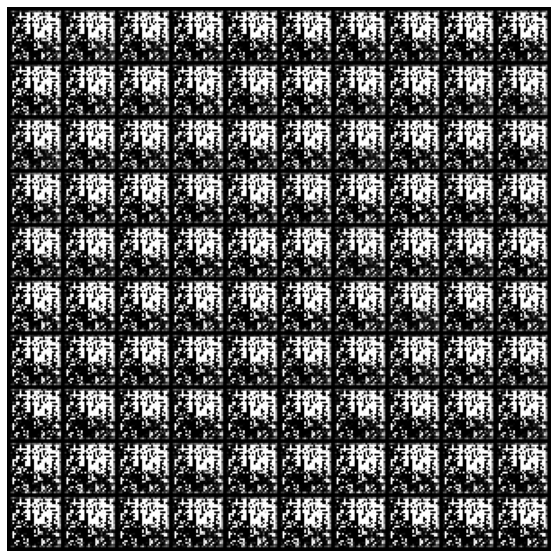

In [36]:
with torch.no_grad():
    gen_data = netG(fixed_noise).detach().cpu()
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
plt.savefig("Epoch_%d_{}".format(params['dataset']) %(params['num_epochs']))


In [0]:
# Save network weights.
torch.save({
    'netG' : netG.state_dict(),
    'discriminator' : discriminator.state_dict(),
    'netD' : netD.state_dict(),
    'netQ' : netQ.state_dict(),
    'optimD' : optimD.state_dict(),
    'optimG' : optimG.state_dict(),
    'params' : params
    }, 'checkpoint/model_final_{}'.format(params['dataset']))

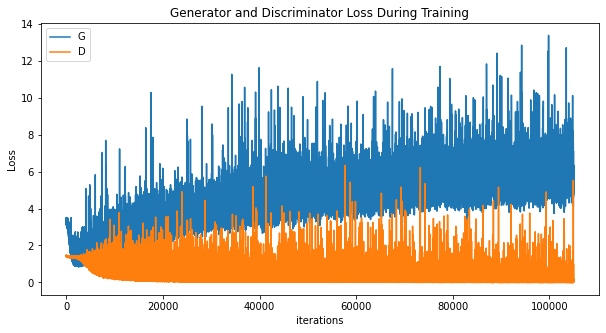

In [38]:
# Plot the training losses.
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("Loss Curve {}".format(params['dataset']))

TypeError: ignored

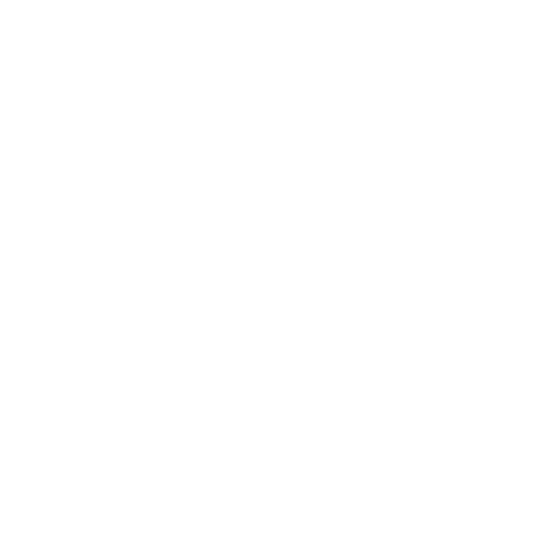

In [39]:
# Animation showing the improvements of the generator.
fig = plt.figure(figsize=(10,10))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
anim.save('infoGAN_{}.gif'.format(params['dataset']), dpi=80, writer='imagemagick')
plt.show()